<a href="https://colab.research.google.com/github/ericdnbn/nn_image_classifier_pneumonia/blob/main/Eric%E2%80%93nn_classifier_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import os, shutil
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers


In [2]:
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test/' 

In [3]:
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneu_dir = os.path.join(train_dir, 'PNEUMONIA')

test_normal_dir = os.path.join(test_dir, 'NORMAL')
test_pneu_dir = os.path.join(test_dir, 'PNEUMONIA')

val_normal_dir = os.path.join(val_dir, 'NORMAL')
val_pneu_dir = os.path.join(val_dir, 'PNEUMONIA')

In [4]:
train_normal_dir

'chest_xray/train/NORMAL'

In [5]:
len(os.listdir(train_normal_dir))

1341

In [7]:
# get all the data in the directory split/train (542 images), and reshape them
arg_dict = {'target_size':(100, 100), 
            'color_mode':'grayscale', 
            'batch_size':50}

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_dir, **arg_dict)


# get all the data in the directory split/test (180 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, **arg_dict) 

# get all the data in the directory split/validation (200 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, **arg_dict)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [8]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [9]:
train_images[0]

array([[[0.6       ],
        [0.5254902 ],
        [0.3254902 ],
        ...,
        [0.25882354],
        [0.29803923],
        [0.427451  ]],

       [[0.59607846],
        [0.5137255 ],
        [0.32941177],
        ...,
        [0.26666668],
        [0.29803923],
        [0.41176474]],

       [[0.6       ],
        [0.61960787],
        [0.38431376],
        ...,
        [0.40784317],
        [0.40784317],
        [0.5411765 ]],

       ...,

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.01176471],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.01176471]]], dtype=float32)

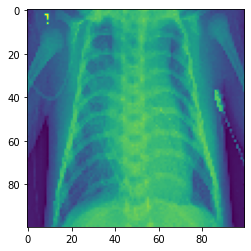

In [10]:
plt.imshow(train_images[3])

In [11]:
train_images.shape[0]

50

In [12]:
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 50
Number of testing samples: 50
Number of validation samples: 16
train_images shape: (50, 100, 100, 1)
train_labels shape: (50, 2)
test_images shape: (50, 100, 100, 1)
test_labels shape: (50, 2)
val_images shape: (16, 100, 100, 1)
val_labels shape: (16, 2)


In [13]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(50, 10000)
(50, 10000)
(16, 10000)


In [14]:
train_y = np.reshape(train_labels[:,0], (50,1))
test_y = np.reshape(test_labels[:,0], (50,1))
val_y = np.reshape(val_labels[:,0], (16,1))

print(train_y)
print(test_y)
print(val_y)

[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]
[[0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [17]:
# First Simple Model
model = models.Sequential()

In [21]:
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(1, activation='sigmoid'))

In [34]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

In [35]:
history = model.fit(train_img, 
                     train_y,
                     epochs=50,
                     batch_size=10,
                     validation_data=(val_img, val_y))

Epoch 1/50
5/5 [==============================] - 1s 119ms/step - loss: 0.0089 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5011 - val_accuracy: 0.8125 - val_recall: 0.6250
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 1.0000 - recall: 1.000 - 0s 29ms/step - loss: 0.0073 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5280 - val_accuracy: 0.8125 - val_recall: 0.6250
Epoch 3/50
5/5 [==============================] - 0s 29ms/step - loss: 0.0073 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4940 - val_accuracy: 0.8125 - val_recall: 0.6250
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 0.0075 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4746 - val_accuracy: 0.8125 - val_recall: 0.6250
Epoch 5/50
5/5 [==============================] - 0s 28ms/step - loss: 0.0069 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4690 - val_accuracy: 0.8125 - val_recall: 0.6250
Epoch 6/50
5/5 [==============================] - 0s 2

Epoch 47/50
5/5 [==============================] - 0s 28ms/step - loss: 0.0040 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5242 - val_accuracy: 0.8125 - val_recall: 0.6250
Epoch 48/50
5/5 [==============================] - 0s 22ms/step - loss: 0.0040 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5254 - val_accuracy: 0.8125 - val_recall: 0.6250
Epoch 49/50
5/5 [==============================] - 0s 28ms/step - loss: 0.0039 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4988 - val_accuracy: 0.8125 - val_recall: 0.6250
Epoch 50/50
5/5 [==============================] - 0s 25ms/step - loss: 0.0040 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5051 - val_accuracy: 0.8125 - val_recall: 0.6250


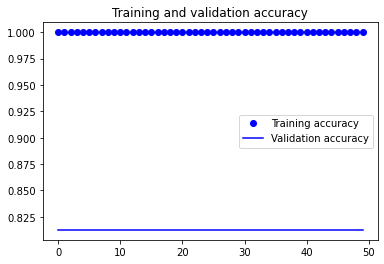

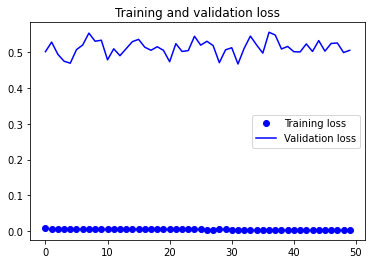

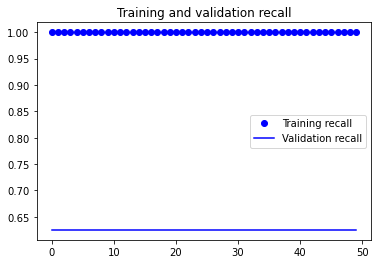

In [39]:

import matplotlib.pyplot as plt
%matplotlib inline 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

In [28]:
results_train = model.evaluate(train_img, train_y)

2/2 [==============================] - 0s 3ms/step - loss: 0.0072 - accuracy: 1.0000


In [29]:
results_train

[0.007243696600198746, 1.0]

In [30]:
results_test = model.evaluate(test_img, test_y)

2/2 [==============================] - 0s 2ms/step - loss: 0.5720 - accuracy: 0.8000


In [31]:
results_test

[0.5720465183258057, 0.800000011920929]

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [51]:
preds = (model.predict(train_img) > 0.5).astype('int32')

cm = confusion_matrix(train_y, preds)

In [52]:
cm

array([[35,  0],
       [ 0, 15]])

In [55]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Nomral', 'Pneumonia'])

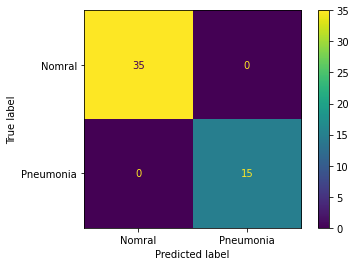

In [60]:
cmd.plot()

In [46]:
def generator(ts_tuple, color, bs_num):

    arg_dict = {'target_size':ts_tuple, 
                'color_mode':color, 
                'batch_size':bs_num}

    train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_dir, **arg_dict)


    # get all the data in the directory split/test (180 images), and reshape them
    test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, **arg_dict) 

    # get all the data in the directory split/validation (200 images), and reshape them
    val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, **arg_dict)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))